In [ ]:
import os

os.environ["GRB_LICENSE_FILE"] = r"C:\Users\tomas\Desktop\gurobi.lic"

import gurobipy as gp
from gurobipy import GRB 


In [28]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Callable, List, Sequence, Tuple, Optional
import math
import gurobipy as gp
from gurobipy import GRB

Vector = List[float]
ForwardBuilder = Callable[[gp.Model], Tuple[List[gp.Var], List[str]]]
FoilBuilder = Callable[[gp.Model, List[gp.Var], List[str]], None]

@dataclass(frozen=True)
class DomainD:
    lb: Sequence[float]
    ub: Sequence[float]

@dataclass
class NCXplainResult:
    status: str
    d_star: Optional[List[float]] = None
    x_foil: Optional[List[float]] = None
    iters: int = 0
    cuts_added: int = 0

# ---------- helpers ----------
def dot(a: Sequence[float], b: Sequence[float]) -> float:
    return sum(float(ai) * float(bi) for ai, bi in zip(a, b))

def _get_solution_vector(x_vars: List[gp.Var]) -> Vector:
    return [float(v.X) for v in x_vars]

def _dot_affine(d_vars: List[gp.Var], x_vals: Sequence[float]) -> gp.LinExpr:
    expr = gp.LinExpr()
    for dj, xj in zip(d_vars, x_vals):
        if abs(xj) > 0:
            expr.add(dj, float(xj))
    return expr

def _dot_bilinear(d_vars: List[gp.Var], x_vars: List[gp.Var]) -> gp.QuadExpr:
    q = gp.QuadExpr()
    for dj, xj in zip(d_vars, x_vars):
        q.add(dj * xj)
    return q

def _is_equal(a: float, b: float, tol: float) -> bool:
    return abs(a - b) <= tol * (1.0 + max(abs(a), abs(b)))

def _is_strictly_less(a: float, b: float, tol: float) -> bool:
    return (b - a) > tol * (1.0 + max(abs(a), abs(b)))

# ---------- Forward SP ----------
def solve_forward_SP(
    forward_builder: ForwardBuilder,
    d: Sequence[float],
    time_limit: Optional[float] = None,
    output_flag: int = 0,
) -> Tuple[str, Vector, float, List[str]]:
    m = gp.Model("SP_forward")
    m.Params.OutputFlag = output_flag
    if time_limit is not None:
        m.Params.TimeLimit = time_limit

    x_vars, var_names = forward_builder(m)

    obj = gp.LinExpr()
    for coeff, var in zip(d, x_vars):
        if abs(coeff) > 0:
            obj.add(var, float(coeff))
    m.setObjective(obj, GRB.MINIMIZE)

    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return "OPTIMAL", _get_solution_vector(x_vars), float(m.ObjVal), var_names
    if m.Status in (GRB.INFEASIBLE, GRB.INF_OR_UNBD):
        return "INFEASIBLE", [], math.inf, var_names
    return f"STATUS_{m.Status}", [], math.inf, var_names

# ---------- Foil membership ----------
def is_in_foil_region(
    forward_builder,
    foil_builder,
    x_candidate,
    output_flag: int = 0,
) -> bool:
    m = gp.Model("foil_membership")
    m.Params.OutputFlag = output_flag

    x_vars, var_names = forward_builder(m)
    foil_builder(m, x_vars, var_names)

    # IMPORTANT: don't use v.VarName here (can error). Use stable indices.
    for j, (v, val) in enumerate(zip(x_vars, x_candidate)):
        m.addConstr(v == float(val), name=f"fix[{j}]")

    m.setObjective(0.0, GRB.MINIMIZE)
    m.optimize()

    if m.Status == GRB.OPTIMAL:
        return True
    if m.Status == GRB.INFEASIBLE:
        return False
    return False


# ---------- Master MP ----------
def solve_master_MPNCE(
    forward_builder: ForwardBuilder,
    foil_builder: FoilBuilder,
    c: Sequence[float],
    domain_d: DomainD,
    S0: List[Vector],
    time_limit: Optional[float] = None,
    output_flag: int = 0,
) -> Tuple[str, List[float], Vector, float, List[str]]:
    n = len(c)
    if len(domain_d.lb) != n or len(domain_d.ub) != n:
        raise ValueError("Domain bounds must match len(c).")
    if len(S0) == 0:
        raise ValueError("S0 must start non-empty (use factual x*).")

    m = gp.Model("MP_NCE")
    m.Params.OutputFlag = output_flag
    if time_limit is not None:
        m.Params.TimeLimit = time_limit
    m.Params.NonConvex = 2  # needed for bilinear terms

    x_vars, var_names = forward_builder(m)
    foil_builder(m, x_vars, var_names)

    g = m.addVars(n, lb=0.0, name="g")
    h = m.addVars(n, lb=0.0, name="h")
    d_vars = m.addVars(n, lb=-GRB.INFINITY, name="d")

    for j in range(n):
        m.addConstr(d_vars[j] == float(c[j]) - g[j] + h[j], name=f"def_d[{j}]")
        m.addConstr(d_vars[j] >= float(domain_d.lb[j]), name=f"d_lb[{j}]")
        m.addConstr(d_vars[j] <= float(domain_d.ub[j]), name=f"d_ub[{j}]")

    for k, x0 in enumerate(S0):
        if len(x0) != len(x_vars):
            raise ValueError(f"S0[{k}] length mismatch.")
        lhs = _dot_bilinear([d_vars[j] for j in range(n)], x_vars)
        rhs = _dot_affine([d_vars[j] for j in range(n)], x0)
        m.addQConstr(lhs <= rhs, name=f"cut[{k}]")

    m.setObjective(g.sum() + h.sum(), GRB.MINIMIZE)
    m.optimize()

    if m.Status == GRB.OPTIMAL:
        d_star = [float(d_vars[j].X) for j in range(n)]
        x_star = _get_solution_vector(x_vars)
        return "OPTIMAL", d_star, x_star, float(m.ObjVal), var_names
    if m.Status in (GRB.INFEASIBLE, GRB.INF_OR_UNBD):
        return "INFEASIBLE", [], [], math.inf, var_names
    return f"STATUS_{m.Status}", [], [], math.inf, var_names

# ---------- NCXplain loop ----------
def ncxplain(
    forward_builder: ForwardBuilder,
    foil_builder: FoilBuilder,
    c: Sequence[float],
    domain_d: DomainD,
    x_factual: Vector,
    max_iters: int = 200,
    tol: float = 1e-7,
    mp_time_limit: Optional[float] = None,
    sp_time_limit: Optional[float] = None,
    output_flag: int = 0,
) -> NCXplainResult:
    S0: List[Vector] = [list(x_factual)]
    cuts_added = 0

    for it in range(1, max_iters + 1):
        mp_status, d_i, x_i, mp_obj, var_names = solve_master_MPNCE(
            forward_builder, foil_builder, c, domain_d, S0,
            time_limit=mp_time_limit, output_flag=output_flag
        )
        if mp_status != "OPTIMAL":
            return NCXplainResult(status=mp_status, iters=it, cuts_added=cuts_added)

        sp_status, x0_i, sp_obj, _ = solve_forward_SP(
            forward_builder, d_i, time_limit=sp_time_limit, output_flag=0
        )
        if sp_status != "OPTIMAL":
            return NCXplainResult(status=f"SP_{sp_status}", iters=it, cuts_added=cuts_added)

        di_xi  = dot(d_i, x_i)
        di_x0  = dot(d_i, x0_i)

        if output_flag:
            print(f"[iter {it}] MP obj ||d-c||1={mp_obj:.6g}  di·x_i={di_xi:.6g}  di·x0={di_x0:.6g}")

        # Case 1
        if _is_equal(di_x0, di_xi, tol):
            return NCXplainResult(status="OPTIMAL", d_star=d_i, x_foil=x_i, iters=it, cuts_added=cuts_added)

        # Case 2
        if _is_strictly_less(di_x0, di_xi, tol) and is_in_foil_region(forward_builder, foil_builder, x0_i):
            return NCXplainResult(status="OPTIMAL", d_star=d_i, x_foil=x_i, iters=it, cuts_added=cuts_added)

        # Case 3
        S0.append(list(x0_i))
        cuts_added += 1

    return NCXplainResult(status="ITER_LIMIT", iters=max_iters, cuts_added=cuts_added)


# ============================================================
# Mixed test instance: continuous x + binary y, objective on both
# ============================================================

def build_mixed_forward(a, B, cx, fy):
    """
    Variables: x_i in [0,1] continuous, y_i in {0,1}
    Constraints:
        sum a_i x_i >= B
        x_i <= y_i
    Objective is passed via d in SP/MP, so forward_builder only builds feasibility,
    but we include both x and y in the returned variable vector.
    """
    n = len(a)
    assert len(cx) == n and len(fy) == n

    def forward_builder(m: gp.Model):
        x = m.addVars(n, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")
        y = m.addVars(n, vtype=GRB.BINARY, name="y")

        m.addConstr(gp.quicksum(a[i] * x[i] for i in range(n)) >= float(B), name="demand")
        for i in range(n):
            m.addConstr(x[i] <= y[i], name=f"link[{i}]")

        # Return vector in fixed order: [x0..xn-1, y0..yn-1]
        vars_out = [x[i] for i in range(n)] + [y[i] for i in range(n)]
        names_out = [f"x[{i}]" for i in range(n)] + [f"y[{i}]" for i in range(n)]
        return vars_out, names_out

    return forward_builder

def foil_force_y_index_on(idx: int, n: int):
    """Foil: force y[idx] = 1 (idx refers to item index; y block starts at position n in returned vector)."""
    def foil_builder(m: gp.Model, vars_out: List[gp.Var], names_out: List[str]):
        y_var = vars_out[n + idx]
        m.addConstr(y_var == 1, name=f"foil_y_on[{idx}]")
    return foil_builder



In [29]:

# -------------------- run the mixed test --------------------

# Data (choose values to make the factual prefer one pattern, foil forces another)
a  = [7, 6, 4, 3]       # coverage coefficients
B  = 8                  # demand threshold

cx = [2.0, 3.0, 0.5, 0.7]   # cost weights on x (continuous usage)
fy = [4.0, 1.0, 3.5, 3.0]   # fixed costs on y (binary activation)

forward_builder = build_mixed_forward(a, B, cx, fy)

n = len(a)

# Objective vector c for NCXplain must match returned vars [x..., y...]
# c = [cx..., fy...]
c = cx + fy

# Factual solve under c
sp_status, x_factual, z_factual, names = solve_forward_SP(forward_builder, c, output_flag=0)
print("Factual status:", sp_status)
print("Factual objective:", z_factual)
print("Factual solution:")
for nm, val in zip(names, x_factual):
    if abs(val) > 1e-9:
        print(f"  {nm} = {val}")

# Foil: force y[0] = 1 (often NOT selected in factual if expensive)
foil_builder = foil_force_y_index_on(idx=0, n=n)

# Domain D around c (small box around each coefficient)
delta = 2.0
domain_d = DomainD(
    lb=[cj - delta for cj in c],
    ub=[cj + delta for cj in c],
)

res = ncxplain(
    forward_builder=forward_builder,
    foil_builder=foil_builder,
    c=c,
    domain_d=domain_d,
    x_factual=x_factual,
    max_iters=200,
    tol=1e-6,
    output_flag=1
)

print("\nNCXplain result:", res.status, "iters=", res.iters, "cuts_added=", res.cuts_added)
print("d* =", res.d_star)
print("foil x (MP solution) nonzeros:")
if res.x_foil is not None:
    for nm, val in zip(names, res.x_foil):
        if abs(val) > 1e-9:
            print(f"  {nm} = {val}")

# Verify forward optimum under d*
if res.d_star is not None:
    sp2_status, x0_star, z0_star, _ = solve_forward_SP(forward_builder, res.d_star, output_flag=0)
    print("\nForward under d* status:", sp2_status, "obj:", z0_star)
    print("Forward-under-d* nonzeros:")
    for nm, val in zip(names, x0_star):
        if abs(val) > 1e-9:
            print(f"  {nm} = {val}")


Factual status: OPTIMAL
Factual objective: 7.0
Factual solution:
  x[1] = 0.6666666666666666
  x[2] = 1.0
  y[1] = 1.0
  y[2] = 1.0
Set parameter OutputFlag to value 1
Set parameter NonConvex to value 2
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
NonConvex  2

Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
Optimize a model with 30 rows, 32 columns and 53 nonzeros (Min)
Model fingerprint: 0x5e763712
Model has 16 linear objective coefficients
Model has 1 quadratic constraint
Variable types: 28 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [7e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS r

In [36]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------
# experiment parameters
# ---------------------------------
n_values = list(range(10, 150, 10))  # 10,20,30,40,50,60,70
n_trials = 30              # increase to 20–30 for smoother curves
max_iters = 30
tol = 1e-6

# ---------------------------------
# helper: build feasible mixed instance
# ---------------------------------
def generate_feasible_instance(n_cont, n_bin, seed):
    rng = np.random.default_rng(seed)

    # Coverage coefficients (x side)
    a = rng.uniform(0.5, 2.0, size=n_cont)

    # Link structure: ensure every x_i has a corresponding y_i
    # Requires n_bin >= n_cont for full linking.
    # If not, we will only link first min(n_cont, n_bin); remaining x_i are "free"
    # which can change structure. Prefer forcing n_bin == n_cont for clean 50/50 when n even.
    # Here we keep your 50/50 design but also enforce linking strongly by setting n_bin = n_cont.
    # If you insist on exact n split for odd n, keep as is and accept partial linking.
    # To preserve your requirement (50/50), we will keep the split but ALSO ensure feasibility via B.

    # Choose B so the demand constraint is feasible even with x_i <= y_i.
    # Worst case: if y forced OFF, x must be 0. But in feasibility, y is a variable, so it can turn ON.
    # Max achievable coverage is sum(a_i * 1) = sum(a_i). We set B as a fraction of that.
    B = 0.40 * float(np.sum(a))

    # Costs: continuous usage and fixed activation
    cx = rng.uniform(0.5, 2.0, size=n_cont)
    fy = rng.uniform(1.0, 3.0, size=n_bin)

    return a, B, cx, fy

# ---------------------------------
# run experiment
# ---------------------------------
rows = []

for n in n_values:
    runtimes = []
    statuses = []
    iters_list = []
    cuts_list = []

    for trial in range(n_trials):
        seed = 10_000 * n + trial  # unique seed per (n, trial)
        random.seed(seed)
        np.random.seed(seed)

        n_cont = n // 2
        n_bin  = n - n_cont

        a, B, cx, fy = generate_feasible_instance(n_cont, n_bin, seed)

        forward_builder = build_mixed_forward(a, B, cx, fy)
        foil_builder    = foil_force_y_index_on(idx=0, n=n_cont)

        c = list(cx) + list(fy)

        # Domain box around c
        delta = 2.0
        domain_d = DomainD(
            lb=[ci - delta for ci in c],
            ub=[ci + delta for ci in c],
        )

        # ---- factual solve ----
        sp_status, x_factual, sp_obj, _ = solve_forward_SP(forward_builder, c, output_flag=0)
        if sp_status != "OPTIMAL":
            # Record and skip this trial
            statuses.append(f"SP_{sp_status}")
            continue

        # ---- ncxplain run ----
        t0 = time.time()
        res = ncxplain(
            forward_builder=forward_builder,
            foil_builder=foil_builder,
            c=c,
            domain_d=domain_d,
            x_factual=x_factual,
            max_iters=max_iters,
            tol=tol,
            output_flag=0
        )
        t1 = time.time()

        statuses.append(res.status)
        runtimes.append(t1 - t0)
        iters_list.append(res.iters)
        cuts_list.append(res.cuts_added)

    # Aggregate only successful runs
    ok_mask = [s == "OPTIMAL" for s in statuses]
    ok_times = [t for t, ok in zip(runtimes, ok_mask) if ok]
    ok_iters = [k for k, ok in zip(iters_list, ok_mask) if ok]
    ok_cuts  = [k for k, ok in zip(cuts_list, ok_mask) if ok]

    row = {
        "n": n,
        "trials": n_trials,
        "n_ok": len(ok_times),
        "mean_time": float(np.mean(ok_times)) if ok_times else np.nan,
        "var_time":  float(np.var(ok_times)) if ok_times else np.nan,
        "mean_iters": float(np.mean(ok_iters)) if ok_iters else np.nan,
        "mean_cuts":  float(np.mean(ok_cuts)) if ok_cuts else np.nan,
        "fail_rate":  1.0 - (len(ok_times) / n_trials),
    }
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("ncxplain_scaling.csv", index=False)
print(df)


      n  trials  n_ok   mean_time      var_time  mean_iters  mean_cuts  \
0    10      30    30    0.018049  9.663171e-05    1.133333   0.133333   
1    20      30    30    0.039293  5.449102e-04    1.133333   0.133333   
2    30      30    30    0.084861  6.661183e-03    1.300000   0.300000   
3    40      30    30    0.159402  2.273947e-02    1.466667   0.466667   
4    50      30    30    0.248350  6.231145e-02    1.566667   0.566667   
5    60      30    30    0.478589  1.583767e-01    1.400000   0.400000   
6    70      30    30    1.448908  4.188733e+00    1.933333   0.933333   
7    80      30    30    0.978244  6.639002e-01    1.300000   0.300000   
8    90      30    30    6.874648  7.988395e+02    1.733333   0.733333   
9   100      30    30    1.688055  1.163283e+01    1.933333   0.933333   
10  110      30    29   23.310447  6.275715e+03    2.172414   1.172414   
11  120      30    30  486.834984  6.104684e+06    1.866667   0.866667   
12  130      30    30    3.817916  2.5

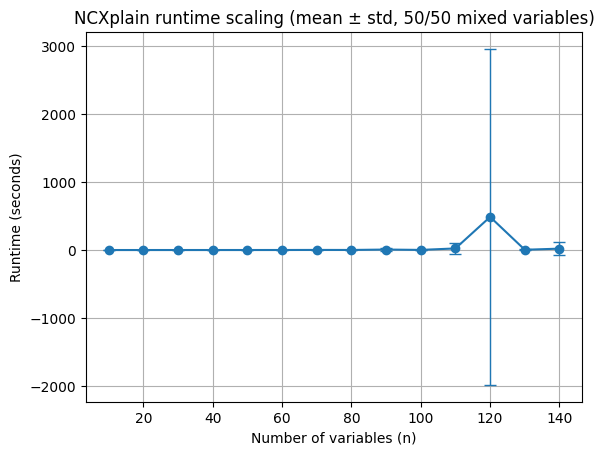

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Compute standard deviation from variance
std_time = np.sqrt(df["var_time"])

plt.figure()
plt.errorbar(
    df["n"],
    df["mean_time"],
    yerr=std_time,
    fmt="o-",
    capsize=4,
    elinewidth=1
)

plt.xlabel("Number of variables (n)")
plt.ylabel("Runtime (seconds)")
plt.title("NCXplain runtime scaling (mean ± std, 50/50 mixed variables)")
plt.grid(True)

plt.show()


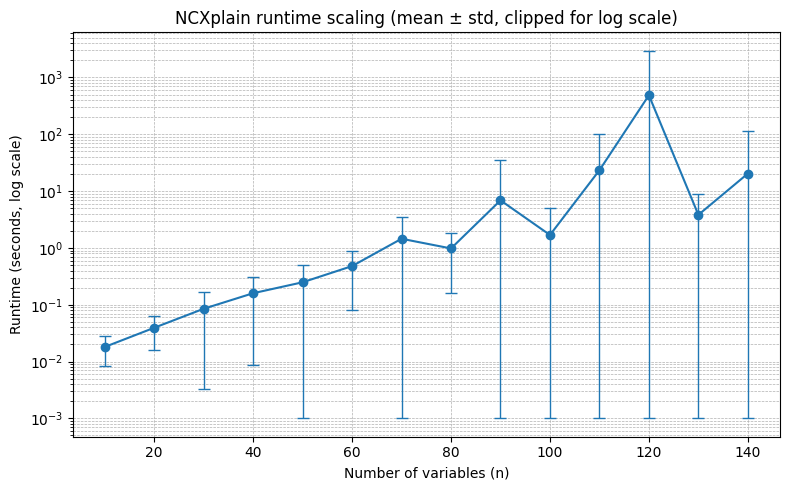

In [44]:
import numpy as np
import matplotlib.pyplot as plt

eps = 1e-3  # avoid log(0)

std_time = np.sqrt(df["var_time"])

mean = np.maximum(df["mean_time"], eps)
lower = np.maximum(mean - std_time, eps)
upper = mean + std_time

plt.figure(figsize=(8,5))
plt.errorbar(
    df["n"],
    mean,
    yerr=[mean - lower, upper - mean],   # asymmetric, nonnegative
    fmt="o-",
    capsize=4,
    elinewidth=1
)

plt.yscale("log")
plt.xlabel("Number of variables (n)")
plt.ylabel("Runtime (seconds, log scale)")
plt.title("NCXplain runtime scaling (mean ± std, clipped for log scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()